In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mpld3
import statsmodels.api as sm

In [113]:
filename = "CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals.csv"
df = pd.read_csv(filename)

In [114]:
# check for missing data, if any
df['rides'].isnull().values.sum()

0

In [115]:
# change date to datetime format
# df['datetime'] = pd.to_datetime(df['date'], format='%m/%d/%Y')

In [118]:
df['rides'] = df.groupby(['stationname','datetime'])['rides'].mean().reset_index()['rides']

In [44]:
# extract season, day of week, month, year
seasons = ['Winter','Winter','Spring','Spring','Spring','Summer',
           'Summer','Summer','Fall','Fall','Fall','Winter']
months = range(1,13)
mtos = dict(zip(months,seasons))
df['season'] = df['datetime'].dt.month.map(mtos)
df['weekday']=df['datetime'].dt.dayofweek.map({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday',
                                              4:'Friday', 5:'Saturday', 6:'Sunday'})
df['month']=pd.DatetimeIndex(df['datetime']).month
df['year']=pd.DatetimeIndex(df['datetime']).year

In [45]:
daytypes = df.daytype.unique().tolist()
daytypedict = dict(zip(daytypes, ['Sun/Hol', 'Weekday', 'Sat']))
df['daytype']=df['daytype'].map(daytypedict)

In [46]:
stations = df.stationname.unique().tolist()
mparklist = ['Washington/Wabash', 'Clark/Lake']

In [47]:
# checking out when stations were closed
count_days = df.groupby('stationname')['rides'].count().reset_index()
day_count_stats = count_days.describe().loc['25%','rides']
count_days[count_days['rides'] < day_count_stats].sort_values(by='rides').reset_index(drop=True).loc[0:9]

,stationname,rides
0,Homan,31
1,Washington/Wabash,334
2,Cermak-McCormick Place,1277
3,Morgan-Lake,2252
4,Dempster-Skokie,2282
5,Oakton-Skokie,2282
6,Washington/State,2953
7,Skokie,4111
8,Madison/Wabash,6216
9,Conservatory,6239


In [48]:
# find trends in ridership (from 2012 to 2017 years)
years_list = np.arange(2017, 2011, -5)
df_diff = df[df['year'].isin(years_list)]
df_diff = df_diff.groupby(['stationname','year'])['rides'].mean().reset_index()

# get rid of stations w/ missing data in 2012 or 2017
df_diff = df_diff.groupby('stationname').filter(lambda x: len(x) >1)

# find change in ridership in past 5 years
df_diff['5yr_diff'] = df_diff['rides'].diff()
df_diff['5yr_percent_diff'] = df_diff['rides'].pct_change()
df_diff = df_diff[df_diff['year']!= 2012]

In [49]:
# get 25 stations with biggest ridership change from 5 years ago
topdiffs = df_diff.sort_values(by=['5yr_diff'], ascending=False).reset_index(drop=True).loc[0:24,:]
topprops = df_diff.sort_values(by=['5yr_percent_diff'], ascending=False).reset_index(drop=True).loc[0:24,:]
top = topdiffs[topdiffs['stationname'].isin(topprops['stationname'])]
topstationlist = top.stationname.unique()

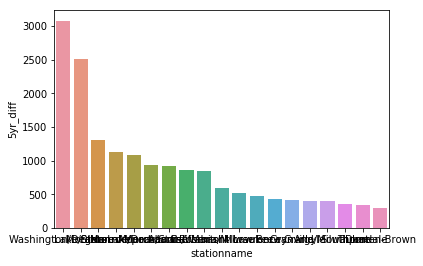

In [50]:
sns.barplot(x='stationname', y='5yr_diff', data=top)

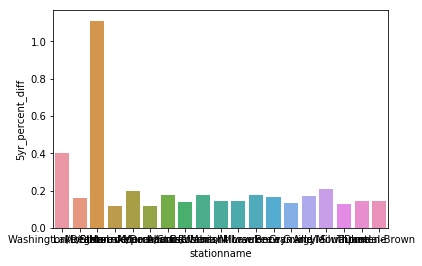

In [51]:
sns.barplot(x='stationname', y='5yr_percent_diff', data=top)

In [52]:
# now get an average change rate over the past 5 years
df_yrdiff=pd.DataFrame()
years_list_5 = np.arange(2017, 2011, -1)
df_yrdiff = df[df['year'].isin(years_list_5)]
df_yrdiff = df_yrdiff.groupby(['stationname','year'])['rides'].mean().reset_index()

# get rid of stations w/ missing data in 2012 or 2017
df_yrdiff = df_yrdiff.groupby('stationname').filter(lambda x: len(x) >5)

# # find change in ridership in past 5 years
df_yrdiff['5yr_diff_ave'] = df_yrdiff['rides'].diff()
df_yrdiff['5yr_percent_diff_ave'] = df_yrdiff['rides'].pct_change()
df_yrdiff = df_yrdiff[df_yrdiff['year']!= 2012]
df_yrdiff=df_yrdiff.groupby('stationname').mean().reset_index()
df_yrdiff['years']=str(years_list_5[0])+'-'+str(years_list_5[-1])

In [53]:
# get 25 stations with biggest ridership change from 5 years ago
topdiffs_ave = df_yrdiff.sort_values(by=['5yr_diff_ave'], ascending=False).reset_index(drop=True).loc[0:24,:]
topprops_ave = df_yrdiff.sort_values(by=['5yr_percent_diff_ave'], ascending=False).reset_index(drop=True).loc[0:24,:]
top_ave = topdiffs_ave[topdiffs_ave['stationname'].isin(topprops['stationname'])]
topstationlist_ave = top_ave.stationname.unique()

In [63]:
df['is_topstation_ave']=df['stationname'].isin(topstationlist_ave)

In [124]:
morse_df = df[df['stationname']=='Morse']
all_dates = pd.date_range(start=morse_df['datetime'].min(), end=morse_df['datetime'].max(), freq='d')
all_dates                                                                

DatetimeIndex(['2001-01-01', '2001-01-02', '2001-01-03', '2001-01-04',
               '2001-01-05', '2001-01-06', '2001-01-07', '2001-01-08',
               '2001-01-09', '2001-01-10',
               ...
               '2018-06-21', '2018-06-22', '2018-06-23', '2018-06-24',
               '2018-06-25', '2018-06-26', '2018-06-27', '2018-06-28',
               '2018-06-29', '2018-06-30'],
              dtype='datetime64[ns]', length=6390, freq='D')

In [125]:
morse_df.groupby('datetime').mean().reset_index()

,datetime,station_id,rides
0,2001-01-01,40100,1010.0
1,2001-01-02,40100,967.0
2,2001-01-03,40100,2.0
3,2001-01-04,40100,1044.0
4,2001-01-05,40100,968.0
5,2001-01-06,40100,875.0
6,2001-01-07,40100,978.0
7,2001-01-08,40100,1035.0
8,2001-01-09,40100,964.0
9,2001-01-10,40100,0.0


In [126]:
morse_df['datetime'].min()
morse_df.min()['datetime']
morse_df[morse_df.datetime.duplicated(keep=False)]

,station_id,stationname,date,daytype,rides,datetime
544160,40100,Morse,07/06/2011,W,680.0,2011-07-06
544212,40100,Morse,07/06/2011,W,675.0,2011-07-06
544571,40100,Morse,07/09/2011,A,621.0,2011-07-09
544620,40100,Morse,07/09/2011,A,620.0,2011-07-09
545177,40100,Morse,07/13/2011,W,612.0,2011-07-13
545293,40100,Morse,07/13/2011,W,676.0,2011-07-13
546260,40100,Morse,07/20/2011,W,449.0,2011-07-20
546304,40100,Morse,07/20/2011,W,598.0,2011-07-20
546700,40100,Morse,07/22/2011,W,310.0,2011-07-22
546703,40100,Morse,07/22/2011,W,273.0,2011-07-22


In [123]:
morse_df.set_index('datetime', drop=True, inplace=True)


In [79]:
decomposition = sm.tsa.seasonal_decompose(m_rides, model='additive', filt=None, freq=None)
fig = decomposition.plot()
plt.show()

ValueError: You must specify a freq or x must be a pandas object with a timeseries index with a freq not set to None

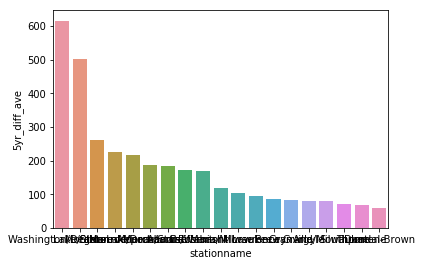

In [54]:
sns.barplot(x='stationname', y='5yr_diff_ave', data=top_ave)

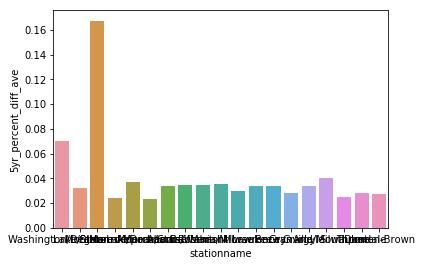

In [55]:
sns.barplot(x='stationname', y='5yr_percent_diff_ave', data=top_ave)

In [56]:
# plot ridership over time
def make_time_plot(df, station):    
    d = df[df['stationname']==station]
    x = 'datetime'
    y = 'rides'
    a=d[x]
    b=d[y]
    fig, ax = plt.subplots()
    ax.plot(a, b)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.title(station)

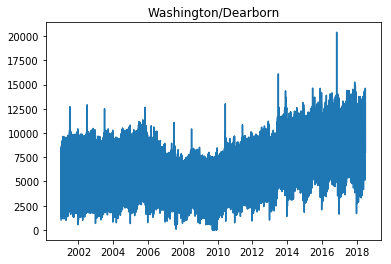

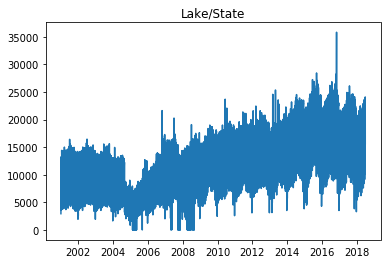

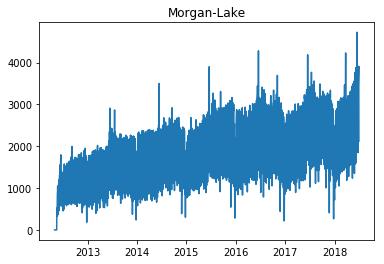

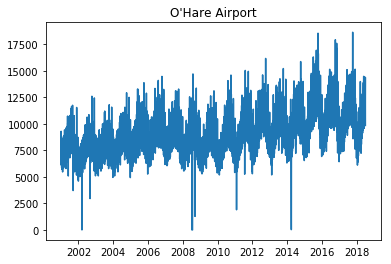

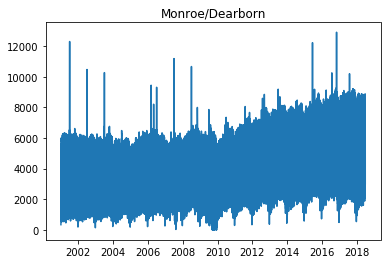

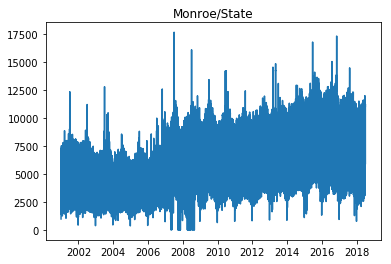

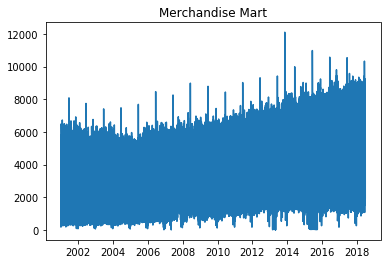

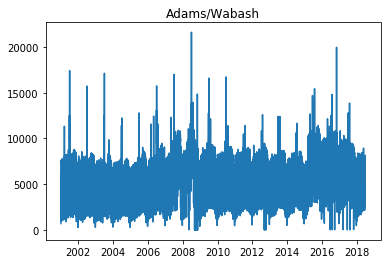

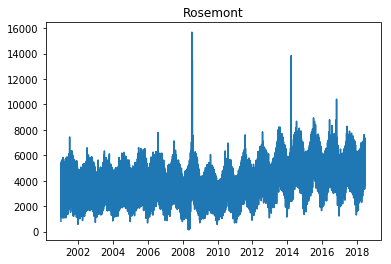

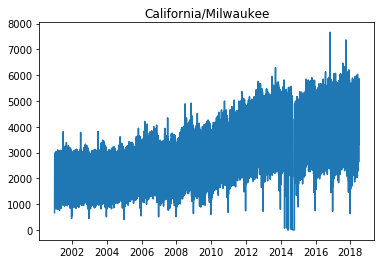

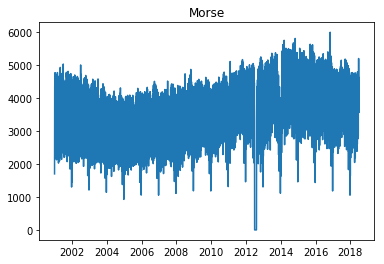

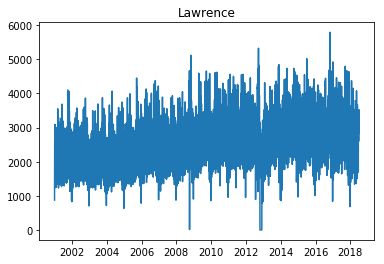

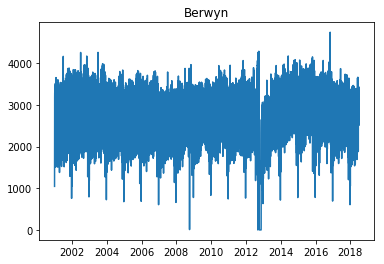

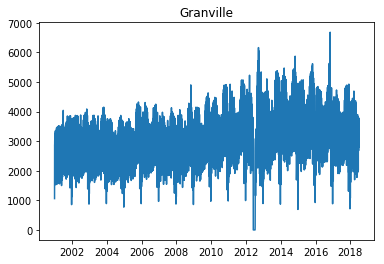

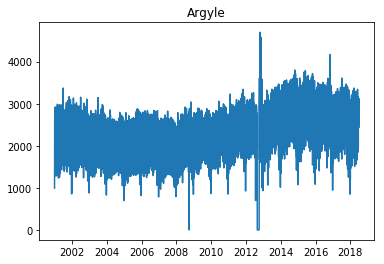

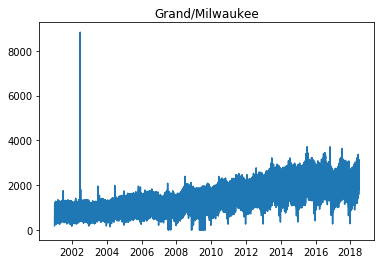

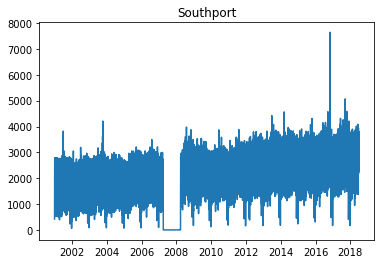

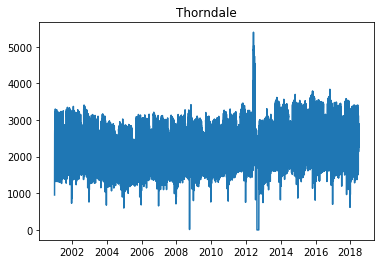

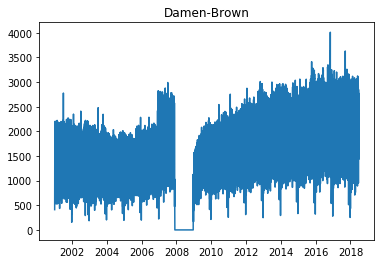

In [57]:
# plots stations with big changes from 2012 to 2017
for stat in topstationlist:
    make_time_plot(df, stat)

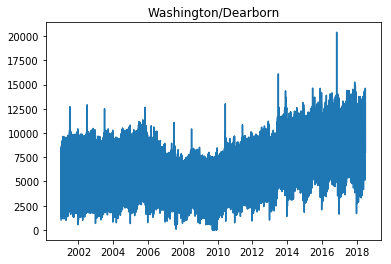

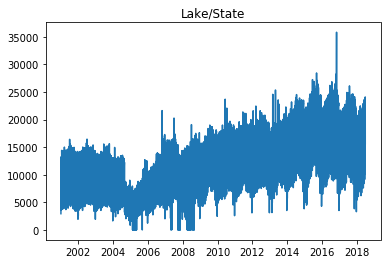

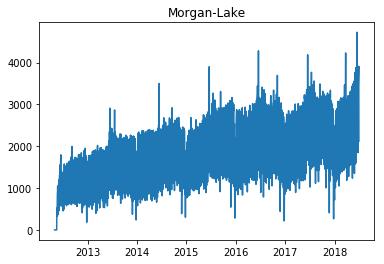

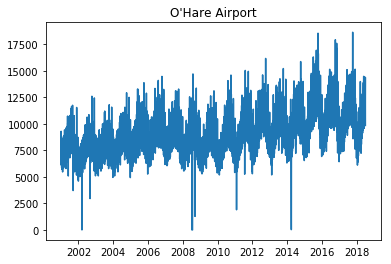

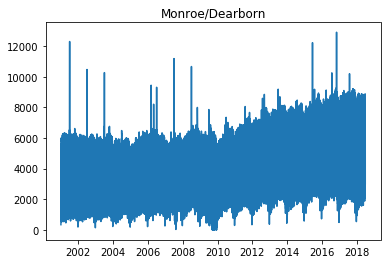

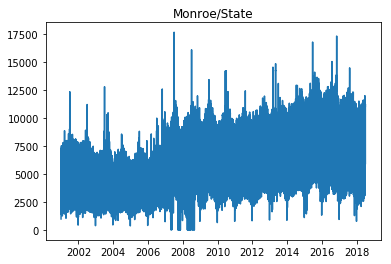

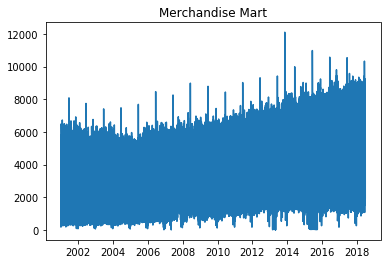

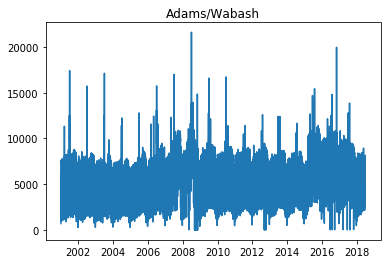

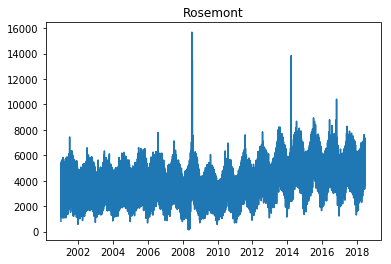

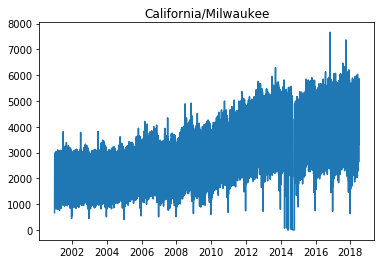

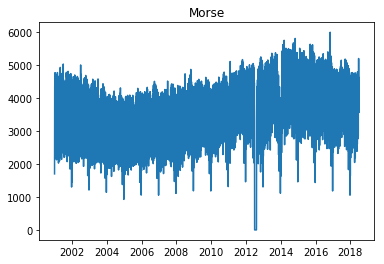

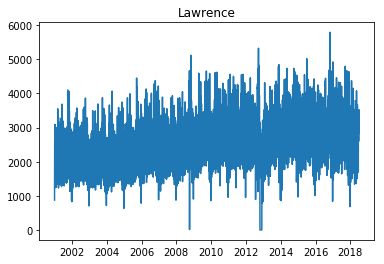

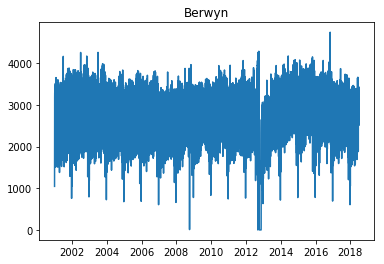

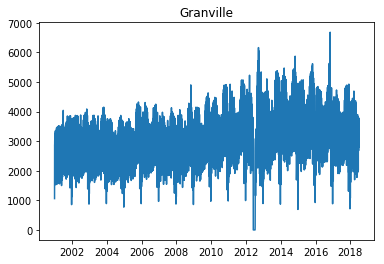

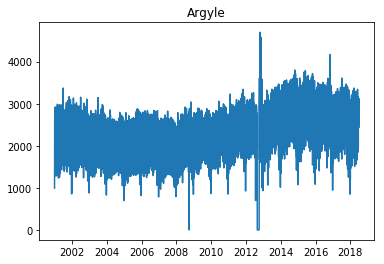

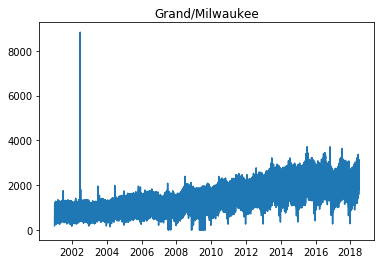

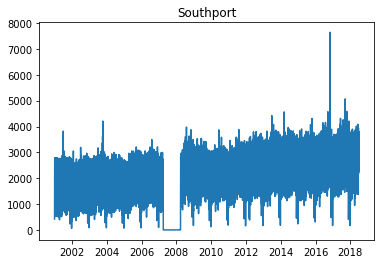

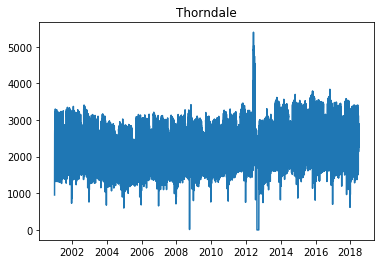

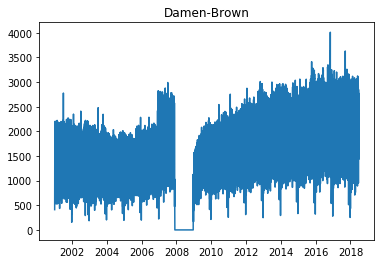

In [19]:
# plots stations with greatest average yearly increases between 2012 and 2017
for stat in topstationlist_ave:
    make_time_plot(df, stat)

In [20]:
def make_layered_hist(array, station, variablename, variablelist):
    fig, ax = plt.subplots()
    for var in variablelist:
        condarray = array[(array['stationname']==station) & (array[variablename]==var)]
        dist=sns.distplot(condarray['rides'], ax=ax, label=var)
        ax.legend()
        ax.set_xlabel('# of Rides Daily', fontsize=16)
    dist=dist.get_figure()
    ax.set_ylabel('Frequency', fontsize=16)
    ax.set_xlim([0,25000])
    plt.title('Distribution of ' + station +' Rides', fontsize=20)
    return fig, ax
#     kde.savefig('figs/react_kde' + condDay + '.png')
#     plt.clf()

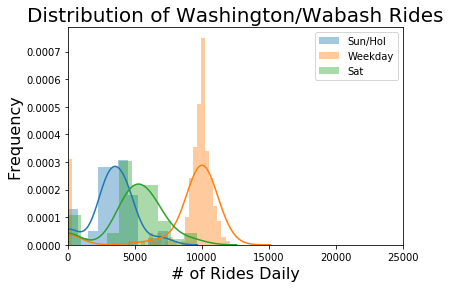

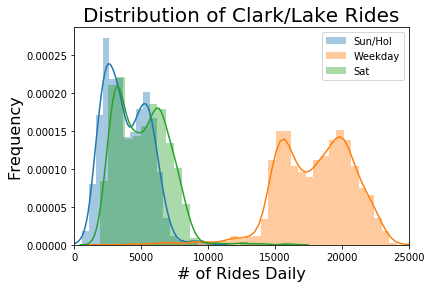

In [21]:
for park in mparklist:
    fig, ax = make_layered_hist(df, park, 'daytype', df['daytype'].unique())

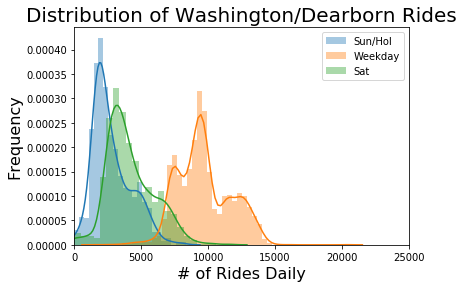

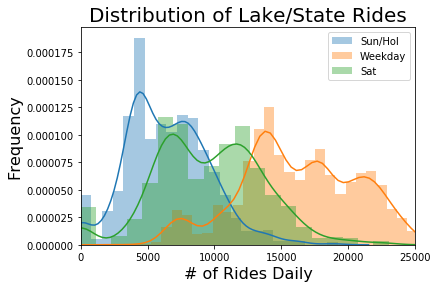

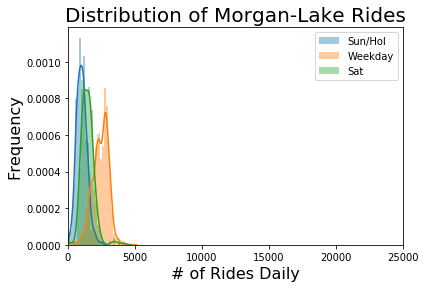

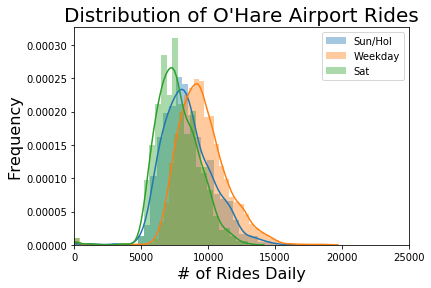

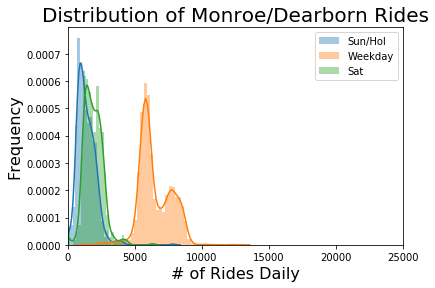

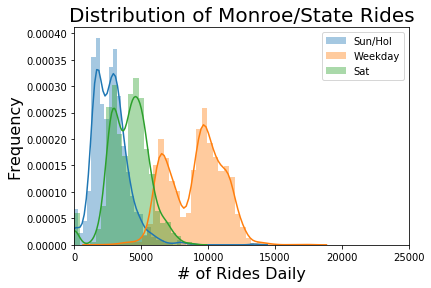

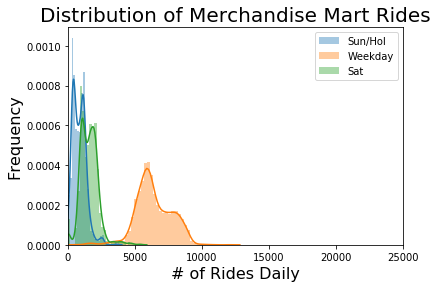

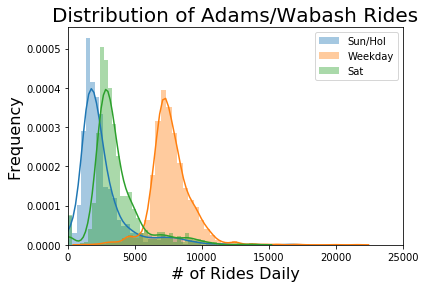

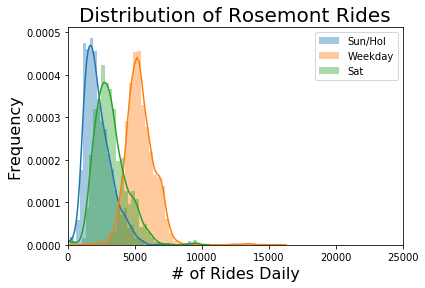

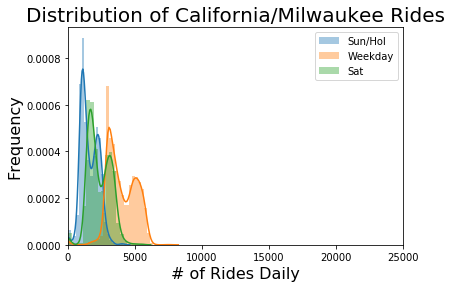

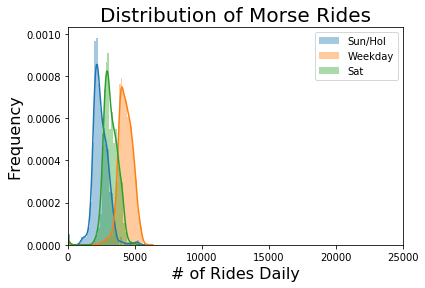

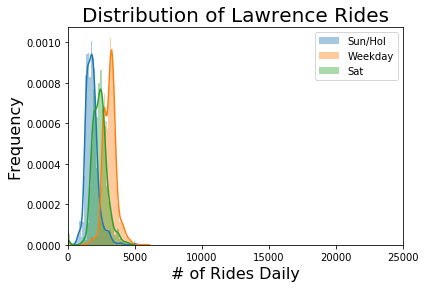

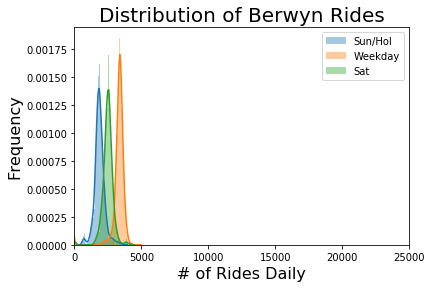

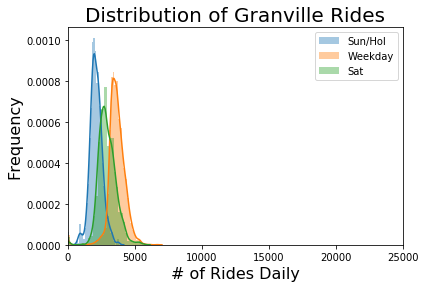

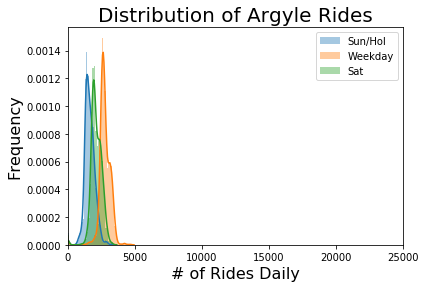

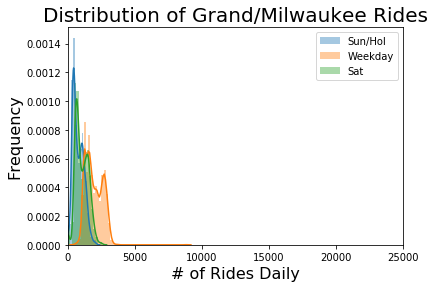

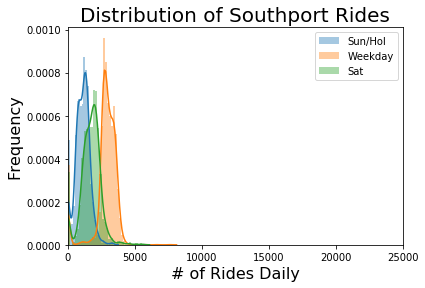

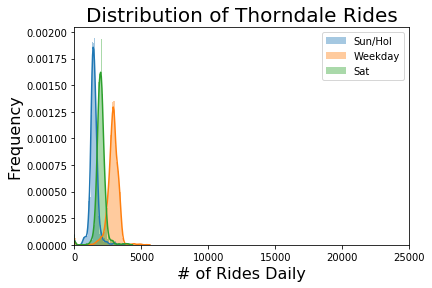

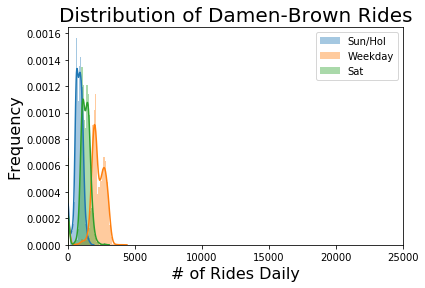

In [22]:
for stat in topstationlist:
    fig, ax = make_layered_hist(df, stat, 'daytype', df['daytype'].unique())

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:823: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


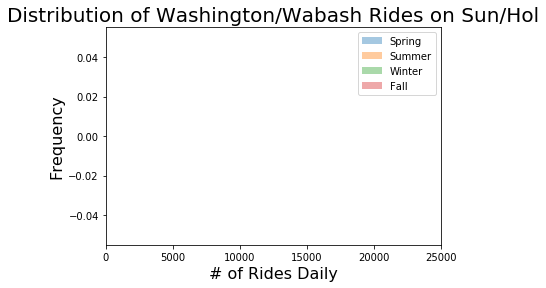

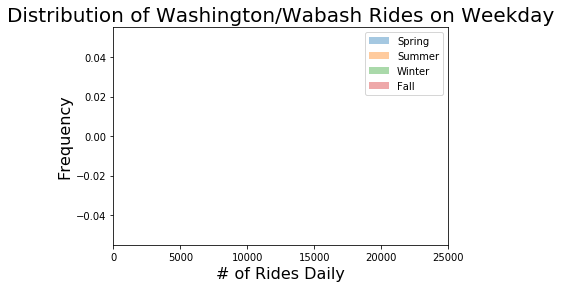

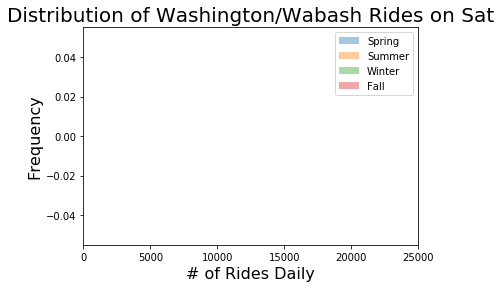

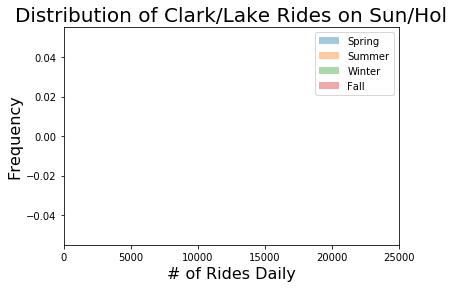

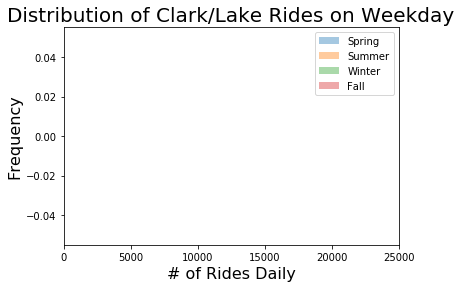

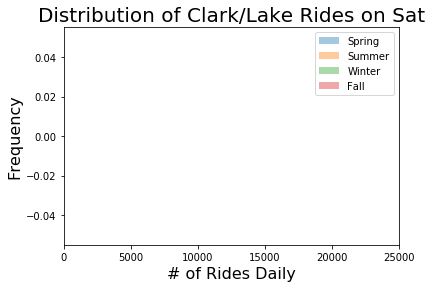

In [23]:
for park in mparklist:
    for day in daytypes:
        fig, ax = make_layered_hist(df[df['daytype']==day], park, 'season', list(set(seasons)))
        plt.title('Distribution of ' + park +' Rides on ' + daytypedict[day], fontsize=20)

In [24]:
y=pd.DataFrame(df.groupby(by=['stationname'])['rides'].mean())
y.loc[y.idxmax()]

,rides
stationname,
Clark/Lake,13900.595838


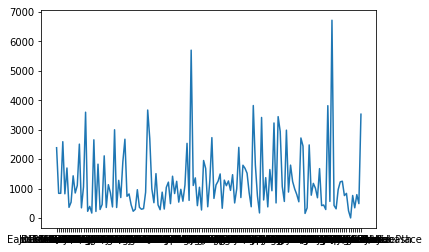

In [25]:
stds = pd.DataFrame(index=stations, columns=['std'])
for station in stations:
    stds.loc[station,'std'] = (df.rides[df['stationname']==station].std())
plt.plot(stds)    

In [3]:
df_map = pd.read_csv('data/CTA_-_System_Information_-_List_of__L__Stops.csv')

In [12]:
loc_string = df_map[df_map['STATION_NAME']=='Morse'].reset_index().loc[0,'Location']

In [17]:
lat,long = loc_string.strip('()').split(',')

In [19]:
float(x)

42.008362

In [15]:
for val in loc_string:
    lat, long = val.strip('()').split(',')
lat    

ValueError: not enough values to unpack (expected 2, got 1)

In [27]:
lats = []
lons = []
for val in df_map.Location:
    lat, long = val.strip('()').split(',')
    lats.append(float(lat))
    lons.append(float(long))
df_map['latitude']=lats  
df_map['longitude']=lons  

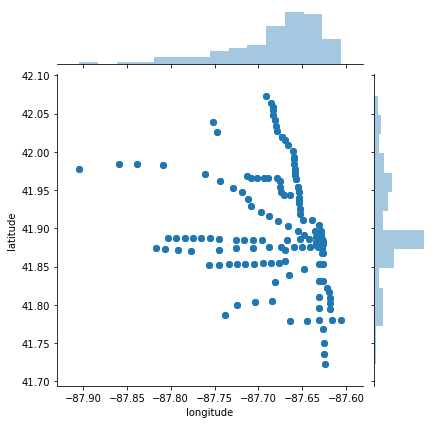

In [28]:
sns.jointplot(x="longitude",y="latitude", data=df_map)

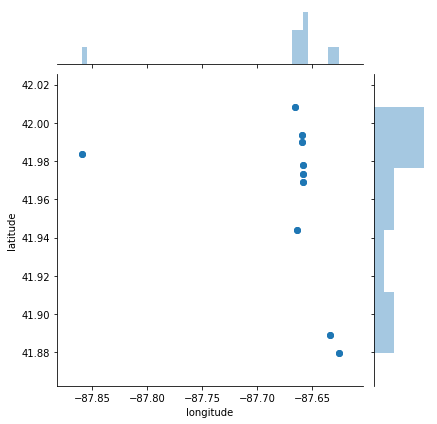

In [29]:
top_map = df_map[df_map['STATION_NAME'].isin(topstationlist)]
top_map.shape
sns.jointplot(x="longitude",y="latitude", data=top_map)

In [30]:
top_rides = top.set_index('stationname')
top_map = top_map.set_index('STATION_NAME')
top_ave_rides = top_ave.set_index('stationname')

In [31]:
all_top = top_map.join(top_ave_rides, how='outer')

In [32]:
all_top.index.tolist()

['Adams/Wabash',
 'Adams/Wabash',
 'Argyle',
 'Argyle',
 'Berwyn',
 'Berwyn',
 'California/Milwaukee',
 'Damen-Brown',
 'Grand/Milwaukee',
 'Granville',
 'Granville',
 'Lake/State',
 'Lawrence',
 'Lawrence',
 'Merchandise Mart',
 'Merchandise Mart',
 'Monroe/Dearborn',
 'Monroe/State',
 'Morgan-Lake',
 'Morse',
 'Morse',
 "O'Hare Airport",
 'Rosemont',
 'Rosemont',
 'Southport',
 'Southport',
 'Thorndale',
 'Thorndale',
 'Washington/Dearborn']

In [39]:
import mpld3

fig, ax = plt.subplots(subplot_kw=dict(facecolor='#EEEEEE'))

scatter = ax.scatter(np.array(all_top.longitude, dtype=float),
                     np.array(all_top.latitude, dtype=float),
                     c=np.random.random(size=len(all_top.latitude)),
                     s=np.array(5000 * all_top['5yr_percent_diff_ave'] , dtype=float),
                     alpha=0.3,
                     cmap=plt.cm.jet)
ax.grid(color='white', linestyle='solid')
ax.set_xlim([-87.9,-87.6])
ax.set_ylim([41.7,42.1])
ax.set_title("Scatter Plot (with tooltips!)", size=20)

labels = all_top.index.tolist()
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()